# TO BE OR NOT TO BE INSURED? 
## How Social Networks Influence One's Decision To Insure

*Andrei Blahovici | Milena Kapralova | Luca Pantea | Paulius Skaisgiris*

This project is part of the Causality course at the UvA during fall 2023. We look at an experiment that investigated how the social environment of rice farmers in rural China influences whether they adopt weather insurance (Cai, De Janvry & Sadoulet, 2015), along with other variables such as demographics or previously adopting weather insurance.
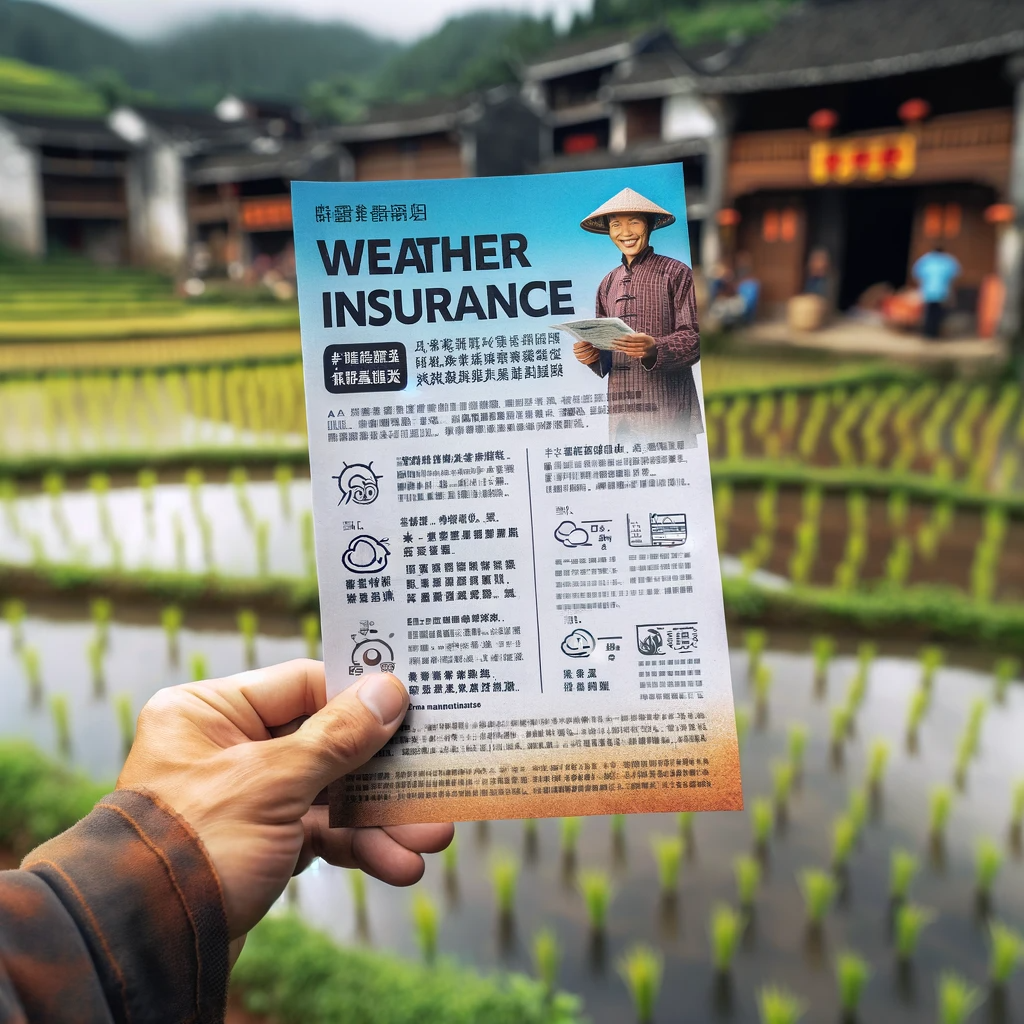

### Imports

In [ ]:
# WARNING:
# The installation takes a few minutes.
# Only run during the first time running this notebook and if you don't have these packages installed.
# Run in terminal command line instead if it does not work.

# !pip install hyppo
# !pip install pingouin
# !pip install conditional_independence
!pip install ipywidgets

In [6]:
import numpy as np
import pandas as pd
from itertools import permutations
import conditional_independence
import hyppo
import matplotlib.pyplot as plt
import networkx as nx
import pingouin as pg
from sklearn import svm
from IPython.display import Image, display
from sklearn.linear_model import LinearRegression
from itertools import chain, combinations

# DoWhy
import dowhy
import dowhy.datasets
from dowhy import CausalModel
from dowhy.causal_identifier import backdoor

# Hide some warnings
import warnings
from sklearn.exceptions import DataConversionWarning

# Seed
np.random.seed(42)

# Configs
plt.rcParams['figure.figsize'] = [5, 5]

## 1 Introduction and Motivation




### Description of the Dataset
- **Data Source**: Data from a randomized experiment in rural China, focusing on weather insurance adoption among rice farmers. You can find the dataset in [this repository](https://github.com/NickCH-K/causaldata/tree/main/Python/causaldata/social-insure).
- **Observational Data**: Includes administrative records of insurance purchases and surveys on social networks, demographics, rice production, income, natural disasters, risk attitudes, and future disaster perceptions.
- **Interventional Data**: The experiment involved providing intensive information sessions about weather insurance to a subset of farmers, generating data on the impact of information dissemination through social networks on insurance uptake.
- **Collection Method**: Data collected through administrative records from the People's Insurance Company of China (PICC) and two surveys - a social network survey pre-experiment and a household survey post-insurance decision.

### Causal Questions Investigated
- **Primary Investigation**: Understanding the influence of social networks on the decision to purchase weather insurance.
- **Specific Questions**:
  1. Does providing intensive information to a subset of farmers increase insurance uptake among their social networks?
  2. Mechanisms of influence - is it through diffusion of insurance knowledge or observation of others' purchase decisions?

### Assumptions of the Dataset
- **Causal Sufficiency**: Assumes no unmeasured confounding variables affecting both network structure and insurance adoption.
- **No Cycles in the Causal Graph**: Assumes a linear progression from information dissemination to changes in insurance adoption, without feedback loops influencing initial information distribution.
- **Positivity**: Every farmer had a non-zero probability of being in both treatment and control conditions due to the randomized nature of the experiment.
- **SUTVA (Stable Unit Treatment Value Assumption)**: Assumes the treatment (information session) for one farmer does not directly affect another farmer's outcome not receiving the treatment, except through defined social networks.
- **Randomization**: Ensures unbiased estimates of treatment effects by randomly assigning farmers to different types of information sessions.

This study provides key insights into the role of social networks in economic decisions, especially in contexts with complex products like weather insurance in rural areas.









<!-- Introduce the datasets, the assumptions and the causal questions you are investigating.

• Describe your dataset (e.g. what are the observational data and how they were collected, in case there are interventional data, also what are they and how they were collected).

• Describe the causal questions you wish to answer (e.g. “we investigate the effect of X on Y”).

• Describe the assumptions of your dataset (causal sufficiency, no cycles in the causal graph, positivity, etc). -->


<!-- <img src=https://d3i71xaburhd42.cloudfront.net/766441c1ab7f4390a5a8c0fa05ec9dc3cd4854d1/58-Figure1-1.png 
     align="center" 
     width="500" />
     
*Source: Shields (2016)* -->



## 2 Exploratory Data Analysis

As shown in Tutorial 2. 

• Testing correlation / dependence for the variables in the dataset and show how they are dependent.

• Discuss the true causal graph of the dataset, if it’s known, and otherwise discuss a reasonable guess.


**Note form the 5th tutorial:
If we see that our relationships between variables is nonlinear, we can try to transform them to become linear. Alternatively, we could use nonparametric tests for dependence (as opposed to the naive, linear gaussian tests) but they require more data (maybe we could try them with 500 samples)**

In [1]:
class ExplorationManager:
    '''
    Takes care of exploratory analyses, including d-separation, visualisation and testing for independences.
    '''
    def __init__(self, data, G=None):
        '''
        :param data: data (df)
        :param G: the graph (a DiGraph object)
        '''
        self.data = data
        self.G = G

    def is_d_separated(self, x, y, z):
        '''
        Verifies whether two (sets of) variables are d-separated by a (set) of variables.
        
        :param x: a set of independent variable(s), len(x) > 0
        :param y: a set of dependent variable(s), len(y) > 0
        :param z: a set of conditioning variables, len(z) >= 0
        '''
        return nx.algorithms.d_separated(G=self.G, x=x, y=y, z=z)

    def visualize_rel(self, x, y):
        '''
        Visualizes the relationship between x and y.

        :param x: the independent variable
        :param y: the dependent variable
        '''
        plt.scatter(x, y)
        plt.gca().set_aspect('equal')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Data distribution')
        plt.show()
    
    def is_dependent(self, x, y, z=[]):
        '''
        Tests  whether two variables are dependent. 
        By default tests for marginal dependence, if z (conditioning set) 
        is specified, tests for conditional dependence.
        
        :param x: an independent variable (str)
        :param y: a dependent variable (str)
        :param z: conditioning set (list)
        
        Returns n, r, 95% CI and a p-value (df).
        '''
        return pg.partial_corr(data=self.data, x=x, y=y, covar=z, method='pearson')

    def is_marginally_dependent(self, x, y):
        '''
        Tests  whether two variables are marginally dependent. 
        
        :param x: an independent variable (list/array)
        :param y: a dependent variable (list/array)
        
        Returns n, r, 95% CI and a p-value, BF10 and power (df).
        '''
        return pg.corr(x=x, y=y, method='pearson')
    
    def is_hsic_dependent(self, x, y):
        '''
        Tests the dependece of two variables using the Hilbert Schmidt Independence Criterion.
        
        :param x: an independent variable (list/array)
        :param y: a dependent variable (list/array)
        
        Returns the hsic statistic and p-value (tuple).
        '''
        hsic, p = hyppo.independence.Hsic().test(x, y)
        return hsic, p
    
    def test_all(self, variables=variables, method='marginal'):
        '''
        Tests dependence of all possible permutations of variables specified.
        By default tests for marginal dependence, if the method variable is changed,
        tests for conditional dependence.
        
        :param variables: all variables to consider (list)
        :param method: {'marginal', 'conditional', 'both'}
        
        Returns a dictionary of p-values.
        '''
        dependence_tests = {}
        
        if method in ['marginal', 'both']:
            for var1, var2 in permutations(variables, 2):
                dependence_tests[var1, var2] = pg.partial_corr(data=self.data, x=var1, y=var2, covar=[], method='pearson')['p-val'].item()
                
        if method in ['conditional', 'both']:
            for var1, var2, cond in permutations(variables, 3):
                 dependence_tests[var1, var2, cond] = pg.partial_corr(data=self.data, x=var1, y=var2, covar=[cond], method='pearson')['p-val'].item()
        
        return dependence tests

## 3 Identifying Estimands

As shown in Tutorials 3 and 4. Identify possible adjustment sets by hand by using:

• Backdoor criterion (most important)

• Frontdoor criterion

• Instrumental variables

Report what happens for these methods even if they don’t apply and explain why. Also show the results you get for each of these estimands from doWhy and compare with the ones you found by hand.

### Backdoor criterion (by hand)

In [ ]:
class BackdoorManager:
    '''
    This class takes care of the backdoor adjustment.
    '''
    def __init__(self, G, node_x, node_y):
        '''
        :param G: graph (a DiGraph object)
        :param node_x: a node whose effect we are trying to predict
        :param node_y: a node effect on which we are trying to predict
        '''
        self.G = G
        self.node_x = node_x
        self.node_y = node_y
        self.descendants_node_x = nx.descendants(self.G, node_x) | {node_x}
        
    def draw(self, pos, edge_color='black'):
        '''
        Draws the graph given a certain position and color of the nodes.
        '''
        nx.draw(self.G, pos=pos, with_labels=True, node_size=500, node_color='w', edgecolors='black', edge_color=edge_color)
        
    def write_gml(self, fname='backdoor_criterion_graph.gml'):
        nx.write_gml(G, fname)
        
    def get_all_paths(self):
        H = self.G.to_undirected()
        all_paths = list(nx.all_simple_paths(H, self.node_x, self.node_y))
        return all_paths
    
    def get_backdoor_paths(self):
        bd = backdoor.Backdoor(self.G, self.node_x, self.node_y)
        all_paths = self.get_all_paths()
        backdoor_paths = [path for path in all_paths if bd.is_backdoor(path)]
        return backdoor_paths
        
    def give_coll_noncoll_on_(self, path):
        '''
        Finds all colliders and non-colliders on a path.
        '''
        colliders = np.array([])
        non_colliders = []
        path_len = len(path)
        
        # Collider
        ## Loop through adjacent variables on the path, ignore the source and target variables as potential colliders
        for node0, node1, node2 in zip(path[0:path_len-2], path[1:path_len-1], path[2:]):
            if self.G.has_edge(node0, node1) and self.G.has_edge(node2, node1):
                ## Add the collider (and all its descendants) to the list
                colliders = np.append(colliders, list(nx.descendants(self.G,node1)) + [node1])
        colliders = colliders.flatten()
        
        # Non-collider
        non_colliders = [x for x in path[1:-1] if x not in colliders]

        return colliders, non_colliders
    
    def find_adjustment_variables(self):
        '''
        Performs the backdoor criterion search.
        '''
        self.adjustment_variables = pd.DataFrame(columns=['path', 'colliders', 'non_colliders'])
        paths = self.get_backdoor_paths()
        
        for path in paths:
            colliders, non_colliders = self.give_coll_noncoll_on_(path)
            self.adjustment_variables.loc[len(self.adjustment_variables.index)] = [path, colliders, non_colliders]
    
    def find_adjustment_sets(self, method='default'):
        '''
        Finds backdoor adjustment sets based on the adjustment variables and method. 
        Default method finds all the minimum-sized and maximum-sized adjustment sets, 
        
        :param method_name: {'default', 'exhaustive-search', 'minimal-adjustment', 'maximal-adjustment', 
                             'efficient-adjustment', 'efficient-minimal-adjustment', 'efficient-mincost-adjustment'}
        '''
        self.find_adjustment_variables()
        colliders = set()
        non_colliders = set()
        
        for index, row in self.adjustment_variables.iterrows():
            colliders.update(row['colliders'])
            non_colliders.update(row['non_colliders'])
        
        # Remove X and Y from the set of nodes that we can condition on
        for terminal in [self.node_x, self.node_y]:
            if terminal in colliders:
                colliders.remove(terminal)
            if terminal in non_colliders:
                non_colliders.remove(terminal)      
            
        candidate_vars = colliders.union(non_colliders)
        
        all_combinations = list(chain.from_iterable(combinations(candidate_vars, r) for r in range(len(candidate_vars)+1)))
        
        # Checking which of the combinations are valid backdoor adjustment sets
        self.adjustment_sets = []
        for candidate_combination in all_combinations:
            valid = True
            candidate_combination = set(candidate_combination)
            for index, row in self.adjustment_variables.iterrows():
                current_colliders = set(row['colliders'])
                current_non_colliders = set(row['non_colliders'])
                
                # Conditions
                cond1 = len(current_colliders.intersection(candidate_combination)) == 0
                cond2 = len(current_non_colliders.intersection(candidate_combination)) > 0 
                cond3 = len(candidate_combination.difference(non_colliders)) == 0
                if len(current_colliders) == 0:
                    combined_cond = cond2
                elif len(current_non_colliders) == 0:
                    combined_cond = cond1
                else:
                    combined_cond = cond1 or cond2

                # Evaluate whether the candidate combination of adjustment variables meets the conditions
                if not combined_cond or (not cond3):
                    valid = False
                    
            if valid:
                self.adjustment_sets.append(candidate_combination)

### Backdoor criterion (DoWhy)

In [ ]:
class BackdoorManagerDoWhy:
    '''
    This class takes care of the backdoor adjustment using DoWhy.
    '''
    def __init__(self, fname='backdoor_criterion_graph.gml'):
        '''
        :param G: the graph (a DiGraph object)
        :param node_x: a node whose effect we are trying to predict
        :param node_y: a node effect on which we are trying to predict
        '''
        self.create_data()
        self.gml_to_string(fname)
        self.model = CausalModel(data = self.data,
                                 treatment='X',
                                 outcome='Y',
                                 graph=self.graph)
    def create_data(self):
        self.data = pd.DataFrame({'A':[1],'B':[1],'C':[1],'D':[1],'W':[1],'X':[1], 'Y': [1], 'Z': [1]})
        
    def gml_to_string(self, file):
        gml_str = ''
        with open(file, 'r') as file:
            for line in file:
                gml_str += line.rstrip()
        self.graph = gml_str

    def draw(self):
        self.model.view_model()
        
    def find_adjustment_sets(self, method_name='default'): 
        '''
        Finds backdoor adjustment sets based on the method. 
        Default method finds all the minimum-sized and maximum-sized adjustment sets, 
        see https://github.com/py-why/dowhy/blob/main/dowhy/causal_model.py
        
        :param method_name: {'default', 'exhaustive-search', 'minimal-adjustment', 'maximal-adjustment', 
                             'efficient-adjustment', 'efficient-minimal-adjustment', 'efficient-mincost-adjustment'}
        '''
        identified_estimand = self.model.identify_effect(method_name=method_name)
        identifier = self.model.identifier
        adjustment_sets = identifier.identify_backdoor(self.model._graph, self.model._treatment, self.model._outcome)
        self.adjustment_sets = [back_set['backdoor_set'] for back_set in adjustment_sets]

### Frontdoor criterion

### Instrumental variables
[here](https://theeffectbook.net/ch-InstrumentalVariables.html?panelset=python-code#how-is-it-performed-3)

### 4 Estimating Causal Effects

As shown in Tutorial 4. Apply and explain different causal estimate methods (linear, inverse propensity weighting, two-stage linear regression, etc.) to the previously identified estimands.

### 5 Causal Discovery

As shown in Tutorials 5 and 6. Try out the two types of algorithms for learning
causal graphs (constraint-based 10 % and score-based 10%). Explain why each method works or doesn’t and what is identifiable in terms of the causal graph.

• Run a constraint-based algorithm (e.g. PC) and a score-based algorithm (e.g. GES) on your data, and report back any identifiable causal relations.

• Optional: If you cannot find any identifiable causal relation or just want to test the algorithms further, simulate some data that resemble your real data (but maybe with less edges).

### 6 Validation and Sensitivity Analysis

Try out different ways to validate the results and do sensitivity analysis of the methods. 

• Report using some of the results of the refutation strategies implemented in DoWhy and interpret what they mean.

• Optional: If your dataset includes interventional data, check that the estimated causal effects from the observational data are reflected in the interventional data.

• Optional: Try experimenting with graphs in which some of the edges are dropped, and see how the results in Section 3 and 4 change.

• Optional: Try relaxing some of the assumptions you discussed in the Introduction, e.g. try to see the effect on not observing a certain variable

### 7 Discussion and Conclusion

In this part you will discuss the results of the previous sections and explain if they do answer the causal questions you described in the Introduction. You can also elaborate on the results you observed in the validation and discuss if the assumptions you had made initially were realistic.

### References

[1] Cai, J., De Janvry, A. and Sadoulet, E., 2015. Social networks and the decision to insure. American Economic Journal: Applied Economics, 7(2), pp.81-108. DOI: 10.1257/app.20130442.

[2] Gretton, A., Fukumizu, K., Teo C., Song L., Schölkopf, B, and Alex Smola. 2007. A Kernel Statistical Test of Independence. Advances in Neural Information Processing Systems, https://proceedings.neurips.cc/paper/2007/file/d5cfead94f5350c12c322b5b664544c1-Paper.pdf.

[3] OpenAI. 2023. "Image of a Rural Chinese Village with Rice Fields and Farmers." DALL-E.

### To-Do:

* Adjust arbitrary data in handcrafter dowhy for backdoor criterion
* Fix the environment?
* Backdoor by hand needs more testing